In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize 
import pandas as pd

In [22]:
def csv_to_np(filename): #changing excel to numpy
    data = pd.read_csv(filename)
    return(np.array(data))

perov = csv_to_np(r'C:\Users\tiann\OneDrive\Desktop\Summer Research 2020\xrdactivitypeaks.csv')#include r to for Python to read '/'

### Exercise 1
To test your import and plotting skills go ahead and write a piece of code in the cell below that will plot the first and last frames of XRD data from the csv we imported in the same figure.



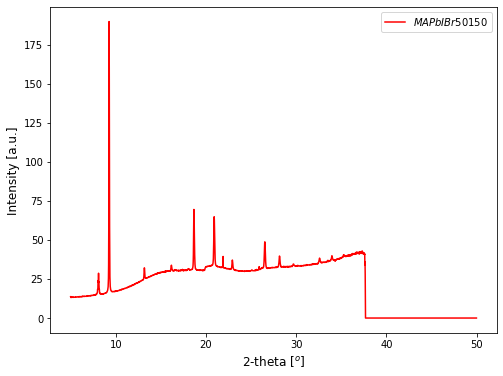

In [105]:
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(perov[:,0],perov[:,1],'r-', label='$MAPbIBr50150$') #plot two-theta versus XRD intesntiy
plt.xlabel('2-theta [$^o$]',size=12) 
plt.ylabel('Intensity [a.u.]',size=12)
plt.legend(loc="upper right")

In [24]:
#Note that our initial 2-theta values are in degrees, not radians
#We also need to define the X-ray wavelength we're using
wave = 0.9763 #wavelength used at SSRL in Angstroms
theta = perov[:,0]/2*np.pi/180 #convert from 2-theta to theta in radians
q = 4*np.pi*np.sin(theta)/wave #convert to q

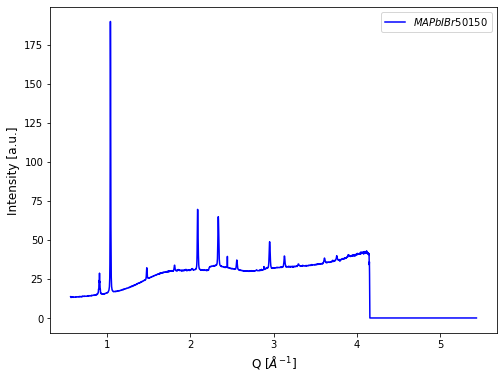

In [104]:
#We can now check that our conversion went as expected by ploting our data versus q
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q,perov[:,1],'b-', label='$MAPbIBr50150$') #plot Q versus XRD intesntiy
plt.xlabel('Q [$\AA^{-1}$]',size=12)
plt.ylabel('Intensity [a.u.]',size=12)
plt.legend(loc="upper right")

## exercise 2
This is a process we'd like to do every time we open a piece of XRD data. Given that, it's worthwhile to make a function that will do this conversion for us. Go ahead and write a function that takes in an array of 2-theta values and a X-ray wavelength $\lambda$, and returns an array of Q values.



In [116]:
import math
wave = 0.9763
theta = perov[:,0]/2*np.pi/180
def two_to_q(two_theta, wave):
    two_theta, wave = np.asarray(two_theta, wave) #to put it as an array if it is not already
    two_theta = perov[:,0]/2*np.pi/180
    4*np.pi*math.sin(two_theta)/wave
    return q
print(q) #this seems correct?

[0.5614436  0.56346351 0.5654834  ... 5.43420073 5.43603348 5.43786609]


In [124]:
def find_nearest(array, target):
    array = np.asarray(array) # In case the input is not an array type
    idx = (np.abs(array - target)).argmin() # Finds the index of the value closest to the target
    return idx
#We use our new function to find the index of real value closest to our desired limit
q = 4*np.pi*np.sin(theta)/wave
q_1 = 0.98 #lower limit for Q we'll consider
q_2 = 1.15 # upper limit - ideally there is only one peak between these values

limit1 = find_nearest(q, q_1) #First our lower limit
limit2 = find_nearest(q, q_2) #And of our higher limit

In [125]:
print(limit1)
print(limit2)

207
292


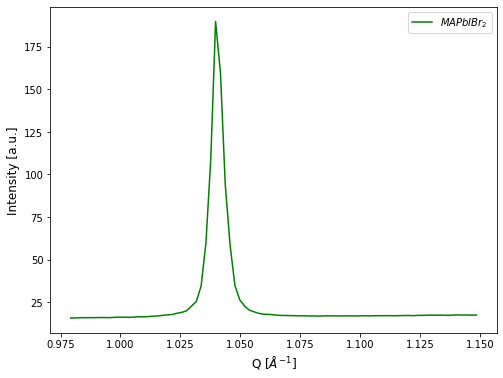

In [131]:
# Having extablished our limits we can now trim the data

q_sub = q[limit1:limit2] # We'll reduce the domain of Q
perov_sub = perov[limit1:limit2, (1,-1)] # And correspondingly shrink the size of our diffraction data set. 
#YOU NEED THE () ABOVE FOR (1,-1) OR ELSE THE CODE WILL NOT FUNCTION

# You'll also notice I'm dropping the first column of data in the perov array, since that's now accounted for in q_sub
#Now let's go ahead and plot again to see if our trimming worked
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_sub[:,0],'g-', label='$MAPbIBr_2$') #plot subfield of data
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper right hand corner

q_linear = np.hstack((q_sub[0:10], q_sub[-11:-1])) #I'm taking the starting and ending values
perov_linear = np.hstack((perov_sub[0:10,0], perov_sub[-11:-1,0])) #We'll use these to fit a straight line
slope, intercept = np.polyfit(q_linear, perov_linear, 1) #Do linear fit
back = slope*q_sub+intercept #Create background array of the form Background = Ax+B


### Exercise 3

In [127]:
def find_nearest(array, target):
    array = np.asarray(array) # In case the input is not an array type
    idx = (np.abs(array - target)).argmin() # Finds the index of the value closest to the target
    return idx
#We use our new function to find the index of real value closest to our desired limit
q = 4*np.pi*np.sin(theta)/wave
q_1 = 0.98 #lower limit for Q we'll consider
q_2 = 1.15 # upper limit - ideally there is only one peak between these values

limit1 = find_nearest(q, q_1) #First our lower limit
limit2 = find_nearest(q, q_2) #And of our higher limit


 
8.364 x + 7.627


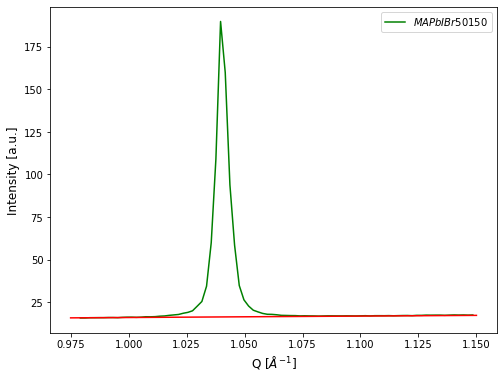

In [130]:
# Using the linear fitting introduced in Tutorial 03, let's fit a straight line for the data around our peak.
# For total transparency this method could be MUCH MUCH better. Open to suggestions!

mypoly= np.poly1d(slope_intercept)
print(mypoly)
xfit = np.linspace(.975, 1.150, num=100)
yfit = mypoly(xfit)

plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_sub[:,0],'g-', label='$MAPbIBr50150$') #plot subfield of data
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper right hand 
plt.plot(xfit, yfit, 'r-', label = 'Best Fit')


##### I don't know how to remove this line

In [83]:
#Let's begin by getting our data ready to analyze
perov_fit = perov_sub[:,0]-back #We'll begin by subtracting the background we calculated for this piece of data

#Now let's define a function we'll want to fit to - this is analagous to the "straight-line-model" from tutorial 03
#We'll call our function gaussian and it will calculate the expression described above
def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

#We'll also give an initial guess for our fits based off of a visual interpretaion of our data
p0 = [250, 1, 0.2]

#Use scipy.optimize.curve_fit to fit our desired data
popt, pcov = scipy.optimize.curve_fit(gaussian, q_sub, perov_fit, p0)

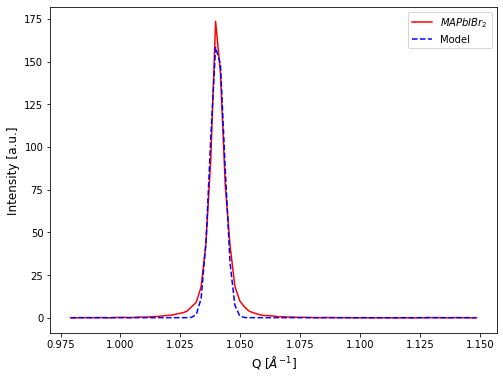

In [32]:
#To confirm our fits it's always nice to plot our model versus our data.
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_fit,'r-', label='$MAPbIBr_2$') #plot subfield of data
plt.plot(q_sub,gaussian(q_sub, *popt),'b--', label='Model') #plot best fit
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

In [63]:
#With confidence in our fit we can now go ahead and print/make note of/tabulate our parameters of interest. 
#Print peak intensity
print('Intensity:', popt[0])

#Caculate and pring d-spacing
d = 2*np.pi/popt[1] #Applying d = 2*pi/Q
print('d-Spacing: ', d) 

#Print lattice constant
miller = [1, 0, 0] #need to guess miller indices of peak
a = d/np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2) #calculate a using a = d/sqrt(h^2+k^2+l^2) for a cubic lattice
print('Lattice Spacing:', a)

Intensity: 163.38860566546327
d-Spacing:  6.039208679674925
Lattice Spacing: 6.039208679674925


In [70]:
# Exercise 4

planes = [[1,1,0], [1,1,1], [2,0,0],]

for plane in planes:
    print(plane)
    # Plot prediction
    
    # Calculate discrepancy

[1, 1, 0]
[1, 1, 1]
[2, 0, 0]


In [133]:
#With confidence in our fit we can now go ahead and print/make note of/tabulate our parameters of interest. 
#Print peak intensity
print('Intensity:', popt[0])

#Caculate and pring d-spacing
d = 2*np.pi/popt[1] #Applying d = 2*pi/Q
print('d-Spacing: ', d) 

#Print lattice constant
miller = [1, 0, 0] #need to guess miller indices of peak
a = d/np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2) #calculate a using a = d/sqrt(h^2+k^2+l^2) for a cubic lattice
print('Lattice Spacing:', a)

Intensity: 163.38860566546327
d-Spacing:  6.039208679674925
Lattice Spacing: 6.039208679674925


### Exercise 4

In [151]:
import numpy as np
import math 
h=3
k=1
l=1
a = 6.04
d = a/(((h**2+k**2+l**2))**.5)
print('d=', d)
lambbda = .9763
Q = (2*np.pi)/d
print('Q=', Q)
theta1 = math.asin((Q*lambbda)/(4*np.pi))
print('theta1', theta1)
answer = theta1*2
print('radian=', answer)
print('angle=', answer*180/np.pi)

d= 1.8211285212496924
Q= 3.450160290097454
theta1 0.27136639399711665
radian= 0.5427327879942333
angle= 31.096298155438046


In [181]:
# Exercise 4
import math
wave = 0.9763
theta = perov[:,0]/2*np.pi/180
def two_to_q(two_theta, wave):
    two_theta, wave = np.asarray(two_theta, wave) #to put it as an array if it is not already
    two_theta = perov[:,0]/2*np.pi/180
    4*np.pi*math.sin(two_theta)/wave
    return q

lambbda = .9763

planes = [[1,1,0], [1,1,1], [2,0,0], [3,0,0]]
two_d = np.array([planes])
print(two_d[:,2]**2)
for plane in planes:
    a = 6.03
    two_d1 = two_d[:,plane]**2
    sumplane = two_d1.sum()
    d = a/((sumplane)**.5)
    print('d=', d)
    lambbda = .9763
    Q = (2*np.pi)/d
    print('Q=', Q)
    theta1 = (math.asin((Q*lambbda)/(4*np.pi)))
    print('theta1', theta1)
    answer = theta1*2
    print('radian=', answer)
    print('angle=', answer*180/np.pi)
    print()

[[4 0 0]]
d= 2.1319269452774408
Q= 2.9471860286290985
theta1 0.2310207355712739
radian= 0.4620414711425478
angle= 26.473026256483607

d= 2.0100000000000002
Q= 3.1259628393928285
theta1 0.2453137531818952
radian= 0.4906275063637904
angle= 28.11088542767313

d= 2.1319269452774408
Q= 2.9471860286290985
theta1 0.2310207355712739
radian= 0.4620414711425478
angle= 26.473026256483607

d= 1.672421091619066
Q= 3.7569397675419487
theta1 0.29619417460035236
radian= 0.5923883492007047
angle= 33.941352241922395

